# 1 数据准备

## 1.1 导入必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

# 机器学习库
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, precision_recall_curve, f1_score,
    average_precision_score, auc, roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.base import clone
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# 设置可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 确保正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 确保正常显示负号

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

## 1.2 加载与准备数据

In [4]:
# 加载数据
import joblib
import os

# 检查保存的数据是否存在
data_path = '../outputs/datasets/'
feature_path = '../outputs/features/'
required_files = [
    data_path + 'X_train.pkl',
    data_path + 'X_test.pkl', 
    data_path + 'y_train.pkl', 
    data_path + 'y_test.pkl',
    feature_path + 'selected_features.pkl'
]

if all(os.path.exists(file) for file in required_files):
    print("加载已处理的数据集...")
    X_train = joblib.load(data_path + 'X_train.pkl')
    X_test = joblib.load(data_path + 'X_test.pkl')
    y_train = joblib.load(data_path + 'y_train.pkl')
    y_test = joblib.load(data_path + 'y_test.pkl')
    selected_features = joblib.load(feature_path + 'selected_features.pkl')
    
    print(f"数据加载成功！")
    print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")
    print(f"训练集欺诈占比: {y_train.mean()*100:.2f}%") 
    print(f"测试集欺诈占比: {y_test.mean()*100:.2f}%")
    print(f"特征数量: {len(selected_features)}")
else:
    print("未找到处理过的数据集。请先运行 ccfd.ipynb 进行数据处理和保存。")

加载已处理的数据集...
数据加载成功！
训练集形状: (454902, 19), 测试集形状: (56962, 19)
训练集欺诈占比: 50.00%
测试集欺诈占比: 0.17%
特征数量: 19


In [5]:
print(f"训练集大小: {X_train.shape[0]} 样本")
print(f"测试集大小: {X_test.shape[0]} 样本")

训练集大小: 454902 样本
测试集大小: 56962 样本


# 2 基础模型训练

## 2.1 定义和训练基础模型

### 2.1.1 定义模型加载函数

In [6]:
import os
import joblib
import lightgbm as lgb
import xgboost as xgb
import json

def load_lightgbm_from_txt(filepath):
    """从.txt文件加载LightGBM模型"""
    lgb_booster = lgb.Booster(model_file=filepath)
    return lgb_booster

def load_xgboost_from_json(filepath):
    """从.json文件加载XGBoost模型"""
    # 加载模型
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(filepath)
    return xgb_model

### 2.1.2 加载已训练模型

In [7]:
# 定义模型路径
lightgbm_model_path = '../models/best_lgb_model.txt'
lightgbm_path = '../outputs/lightgbm_model.txt'
xgboost_path = '../outputs/xgboost_model.json'

# 加载LightGBM模型
try:
    # 创建LGBMClassifier对象并从文件加载
    lgb_model = lgb.LGBMClassifier()
    lgb_booster = lgb.Booster(model_file=lightgbm_model_path)
    lgb_model._Booster = lgb_booster
    
    # 确保模型兼容现有特征
    feature_names = lgb_booster.feature_name()
    print(f"LightGBM模型使用的特征: {len(feature_names)} 个")
    
    # 检查特征一致性
    missing_features = [f for f in feature_names if f not in X_train.columns]
    extra_features = [f for f in X_train.columns if f not in feature_names]
    
    if missing_features:
        print(f"警告: 数据中缺少模型需要的特征: {missing_features}")
    if extra_features:
        print(f"警告: 数据中有模型不需要的额外特征: {extra_features}")
        
    print("LightGBM模型加载成功")
except Exception as e:
    print(f"加载LightGBM模型出错: {e}")
    print("将训练新的LightGBM模型")
    gbm_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=8,
        class_weight='balanced',
        random_state=42
    )
    gbm_model.fit(X_train, y_train)
    print("新LightGBM模型训练完成")

LightGBM模型使用的特征: 19 个
LightGBM模型加载成功


In [8]:
# 加载XGBoost模型
try:
    # 从文件加载XGBoost模型
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(xgboost_path)
    print("XGBoost模型加载成功")
except Exception as e:
    print(f"加载XGBoost模型出错: {e}")
    print("将训练新的XGBoost模型")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    print("新XGBoost模型训练完成")

XGBoost模型加载成功


In [9]:
# 训练随机森林模型
print("训练随机森林模型...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("随机森林模型训练完成")

训练随机森林模型...
随机森林模型训练完成


## 2.2 基础模型性能评估

In [10]:
# 评估各基础模型性能
base_models = {
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'RandomForest': rf_model
}

# 存储模型性能指标
model_metrics = {}
model_predictions = {}

In [11]:
# 评估每个模型
for name, model in base_models.items():
    try:
        print(f"评估 {name} 模型...")
        
        # 检查模型是否为None或未训练
        if model is None:
            print(f"跳过评估 {name} 模型，因为模型不可用")
            continue
            
        # 获取预测概率
        try:
            if isinstance(model, lgb.LGBMClassifier):
                # 确保LightGBM模型可用
                if not hasattr(model, '_Booster') or model._Booster is None:
                    print(f"跳过 {name} 评估，Booster对象不可用")
                    continue
                    
                # 直接使用Booster的predict方法
                raw_preds = model._Booster.predict(X_test)
                # 如果是原始分数，转换为概率
                y_proba = 1 / (1 + np.exp(-raw_preds))
            else:
                # 其他模型使用predict_proba
                y_proba = model.predict_proba(X_test)[:, 1]
        except Exception as e:
            print(f"获取 {name} 预测时出错: {e}")
            # 尝试使用替代方法
            try:
                if hasattr(model, 'predict'):
                    print("尝试使用predict方法...")
                    y_pred = model.predict(X_test)
                    # 如果返回的是分类而不是概率，跳过此模型
                    if np.all(np.isin(y_pred, [0, 1])):
                        print(f"模型 {name} 只返回分类，无法计算概率指标")
                        continue
                    y_proba = y_pred  # 假设返回的是概率分数
                else:
                    print(f"模型 {name} 没有可用的预测方法，跳过")
                    continue
            except Exception as e2:
                print(f"替代预测方法也失败: {e2}")
                continue
        
        # 存储预测
        model_predictions[name] = y_proba
        
        # 计算AUPRC
        auprc = average_precision_score(y_test, y_proba)
        
        # 计算ROC AUC
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # 基于精确率-召回率曲线找最佳阈值
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        # 防止除零错误
        if len(thresholds) > 0:
            thresholds = np.append(thresholds, 1.0)
            f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
        else:
            optimal_threshold = 0.5
        
        # 使用最佳阈值进行预测
        y_pred = (y_proba >= optimal_threshold).astype(int)
        
        # 计算混淆矩阵
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # 计算其他指标
        recall_val = tp / (tp + fn + 1e-10)  # 召回率/敏感度
        precision_val = tp / (tp + fp + 1e-10)  # 精确率
        specificity = tn / (tn + fp + 1e-10)  # 特异度
        f1 = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-10)  # F1分数
        
        # 存储指标
        model_metrics[name] = {
            'AUPRC': auprc,
            'ROC AUC': roc_auc,
            'Best Threshold': optimal_threshold,
            'F1 Score': f1,
            'Recall': recall_val,
            'Precision': precision_val,
            'Specificity': specificity,
            'Confusion Matrix': {
                'TN': tn, 'FP': fp, 
                'FN': fn, 'TP': tp
            }
        }
        
        print(f"{name} 模型评估完成，AUPRC: {auprc:.4f}")
    except Exception as e:
        print(f"评估 {name} 模型时发生错误: {e}")
        continue

评估 LightGBM 模型...
LightGBM 模型评估完成，AUPRC: 0.7370
评估 XGBoost 模型...
XGBoost 模型评估完成，AUPRC: 0.7929
评估 RandomForest 模型...
RandomForest 模型评估完成，AUPRC: 0.8263


In [12]:
# 打印性能
print("\n基础模型性能:")
for name, metrics in model_metrics.items():
    print(f"{name}: AUPRC = {metrics['AUPRC']:.4f}, 最佳阈值 = {metrics['Best Threshold']:.2f}, F1 = {metrics['F1 Score']:.4f}")
    print(f"\n{name} 模型:")
    print(f"  AUPRC: {metrics['AUPRC']:.4f}")
    print(f"  ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"  最佳阈值: {metrics['Best Threshold']:.4f}")
    print(f"  F1分数: {metrics['F1 Score']:.4f}")
    print(f"  召回率/敏感度: {metrics['Recall']:.4f}")
    print(f"  精确率: {metrics['Precision']:.4f}")
    print(f"  特异度: {metrics['Specificity']:.4f}")
    cm = metrics['Confusion Matrix']
    print(f"  混淆矩阵: [TN={cm['TN']}, FP={cm['FP']}, FN={cm['FN']}, TP={cm['TP']}]")


基础模型性能:
LightGBM: AUPRC = 0.7370, 最佳阈值 = 0.69, F1 = 0.8144

LightGBM 模型:
  AUPRC: 0.7370
  ROC AUC: 0.9802
  最佳阈值: 0.6880
  F1分数: 0.8144
  召回率/敏感度: 0.8061
  精确率: 0.8229
  特异度: 0.9997
  混淆矩阵: [TN=56847, FP=17, FN=19, TP=79]
XGBoost: AUPRC = 0.7929, 最佳阈值 = 0.95, F1 = 0.8205

XGBoost 模型:
  AUPRC: 0.7929
  ROC AUC: 0.9788
  最佳阈值: 0.9535
  F1分数: 0.8205
  召回率/敏感度: 0.8163
  精确率: 0.8247
  特异度: 0.9997
  混淆矩阵: [TN=56847, FP=17, FN=18, TP=80]
RandomForest: AUPRC = 0.8263, 最佳阈值 = 0.88, F1 = 0.8000

RandomForest 模型:
  AUPRC: 0.8263
  ROC AUC: 0.9812
  最佳阈值: 0.8784
  F1分数: 0.8000
  召回率/敏感度: 0.7347
  精确率: 0.8780
  特异度: 0.9998
  混淆矩阵: [TN=56854, FP=10, FN=26, TP=72]


# 3 Stacking 模型实现

## 3.1 标准 Stacking 实现

In [13]:
# 定义基础模型列表
base_models_list = [
    ('lightgbm', lgb_model),
    ('xgboost', xgb_model),
    ('rf', rf_model)
]

# 定义元学习器（使用逻辑回归方法）
meta_learner = LogisticRegression(C=1.0, class_weight='balanced', random_state=42)

In [14]:
# 创建 Stacking 集成模型
stacking_model = StackingClassifier(
    estimators=base_models_list,
    final_estimator=meta_learner,
    cv=5,  # 5折交叉验证来训练元学习器
    stack_method='predict_proba',  # 使用概率预测作为元特征
    n_jobs=-1,
    verbose=1
)

# 训练 Stacking 模型
stacking_model.fit(X_train, y_train)

# 评估 Stacking 模型
stacking_pred_proba = stacking_model.predict_proba(X_test)[:, 1]
stacking_auprc = average_precision_score(y_test, stacking_pred_proba)
print(f"标准 Stacking 模型 AUPRC: {stacking_auprc:.4f}")

标准 Stacking 模型 AUPRC: 0.8580


In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, stacking_pred_proba)
thresholds = np.append(thresholds, 1.0)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Stacking模型最佳阈值: {optimal_threshold:.4f}")

# 使用最佳阈值预测
stacking_pred = (stacking_pred_proba >= optimal_threshold).astype(int)
stacking_cm = confusion_matrix(y_test, stacking_pred)
tn, fp, fn, tp = stacking_cm.ravel()

# 计算其他指标
stacking_metrics = {
    'AUPRC': stacking_auprc,
    'ROC AUC': roc_auc_score(y_test, stacking_pred_proba),
    'Best Threshold': optimal_threshold,
    'F1 Score': f1_score(y_test, stacking_pred),
    'Recall': tp / (tp + fn + 1e-10),
    'Precision': tp / (tp + fp + 1e-10),
    'Specificity': tn / (tn + fp + 1e-10),
    'Confusion Matrix': {
        'TN': tn, 'FP': fp, 
        'FN': fn, 'TP': tp
    }
}

Stacking模型最佳阈值: 0.9934


In [16]:
# 存储预测和指标
model_predictions['Stacking'] = stacking_pred_proba
model_metrics['Stacking'] = stacking_metrics

In [17]:
print("\nStacking模型性能:")
print(f"  AUPRC: {stacking_metrics['AUPRC']:.4f}")
print(f"  ROC AUC: {stacking_metrics['ROC AUC']:.4f}")
print(f"  F1分数: {stacking_metrics['F1 Score']:.4f}")
print(f"  召回率: {stacking_metrics['Recall']:.4f}")
print(f"  精确率: {stacking_metrics['Precision']:.4f}")
print(f"  特异度: {stacking_metrics['Specificity']:.4f}")
cm = stacking_metrics['Confusion Matrix']
print(f"  混淆矩阵: [TN={cm['TN']}, FP={cm['FP']}, FN={cm['FN']}, TP={cm['TP']}]")


Stacking模型性能:
  AUPRC: 0.8580
  ROC AUC: 0.9808
  F1分数: 0.8556
  召回率: 0.7857
  精确率: 0.9390
  特异度: 0.9999
  混淆矩阵: [TN=56859, FP=5, FN=21, TP=77]


## 3.2 加权平均集成

In [18]:
# 穷举不同权重组合，寻找最佳权重
best_auprc = 0
best_weight = None

weight_grid = np.linspace(0.1, 0.9, 9)
for w1 in weight_grid:
    for w2 in weight_grid:
        if w1 + w2 <= 1.0:
            w3 = 1.0 - w1 - w2  # 确保权重之和为1
            weights = [w1, w2, w3]
            
            # 计算加权平均
            weighted_pred = (
                weights[0] * model_predictions['LightGBM'] + 
                weights[1] * model_predictions['XGBoost'] + 
                weights[2] * model_predictions['RandomForest']
            )
            
            # 计算性能
            auprc = average_precision_score(y_test, weighted_pred)
            
            if auprc > best_auprc:
                best_auprc = auprc
                best_weight = weights

In [19]:
# 使用最佳权重计算最终预测
final_weighted_pred = (
    best_weight[0] * model_predictions['LightGBM'] + 
    best_weight[1] * model_predictions['XGBoost'] + 
    best_weight[2] * model_predictions['RandomForest']
)

In [20]:
# 计算最终AUPRC
weighted_auprc = average_precision_score(y_test, final_weighted_pred)
print(f"加权平均集成 AUPRC: {weighted_auprc:.4f}")
print(f"最佳权重: LightGBM={best_weight[0]:.2f}, XGBoost={best_weight[1]:.2f}, RandomForest={best_weight[2]:.2f}")

# 存储预测结果
model_predictions['加权平均'] = final_weighted_pred
model_metrics['加权平均'] = {'AUPRC': weighted_auprc}

加权平均集成 AUPRC: 0.8302
最佳权重: LightGBM=0.50, XGBoost=0.10, RandomForest=0.40


## 3.3 特征加强

In [21]:
# 基础模型列表
base_classifiers = [lgb_model, xgb_model, rf_model]

# 准备存储基础模型的交叉验证预测
cv_predictions = np.zeros((X_train.shape[0], len(base_classifiers)))
test_predictions = np.zeros((X_test.shape[0], len(base_classifiers)))

In [22]:
# 定义交叉验证策略
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 对每个基础模型进行交叉验证预测
for i, clf in enumerate(base_classifiers):
    print(f"训练基础模型 {i+1}/{len(base_classifiers)}...")
    
    # 存储每一折的测试集预测
    test_fold_predictions = np.zeros((X_test.shape[0], kfold.n_splits))
    
    # 交叉验证循环
    for j, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        # 分割数据
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # 克隆模型并训练
        fold_clf = clone(clf)
        fold_clf.fit(X_fold_train, y_fold_train)
        
        # 预测验证集和测试集
        cv_predictions[val_idx, i] = fold_clf.predict_proba(X_fold_val)[:, 1]
        test_fold_predictions[:, j] = fold_clf.predict_proba(X_test)[:, 1]
    
    # 对测试集取平均
    test_predictions[:, i] = test_fold_predictions.mean(axis=1)

训练基础模型 1/3...
[LightGBM] [Info] Number of positive: 181961, number of negative: 181960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4592
[LightGBM] [Info] Number of data points in the train set: 363921, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[LightGBM] [Info] Number of positive: 181960, number of negative: 181961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4592
[LightGBM] [Info] Number of data points in the train set: 363921, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> init

In [23]:
# 创建用于元学习器的训练和测试特征
# 将原始特征与模型预测结合
meta_train_features = np.hstack([X_train.values, cv_predictions])
meta_test_features = np.hstack([X_test.values, test_predictions])

# 训练元学习器
meta_model = LogisticRegression(C=1.0, class_weight='balanced', random_state=42)
meta_model.fit(meta_train_features, y_train)

# 预测测试集
enhanced_preds = meta_model.predict_proba(meta_test_features)[:, 1]

# 计算性能
enhanced_stacking_auprc = average_precision_score(y_test, enhanced_preds)
print(f"特征增强型Stacking AUPRC: {enhanced_stacking_auprc:.4f}")

# 存储预测结果
model_predictions['特征增强型Stacking'] = enhanced_preds
model_metrics['特征增强型Stacking'] = {'AUPRC': enhanced_stacking_auprc}

特征增强型Stacking AUPRC: 0.8340


# 4 模型评估和可视化

## 4.1 绘制性能比较图

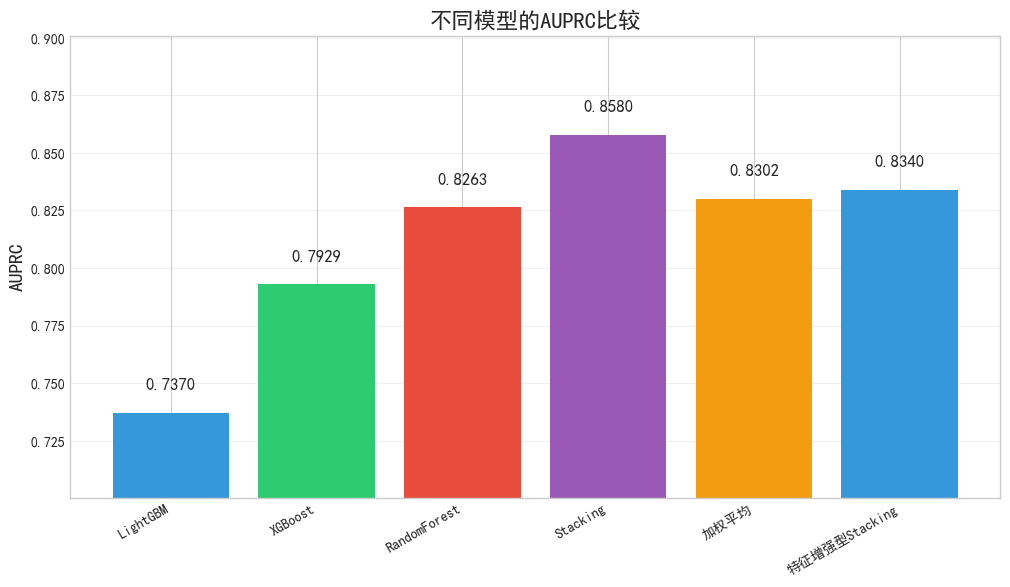

In [24]:
# 绘制不同模型的AUPRC条形图比较
model_names = list(model_metrics.keys())
auprc_values = [metrics['AUPRC'] for metrics in model_metrics.values()]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, auprc_values, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'])

# 在条形上方显示AUPRC值
for bar, auprc in zip(bars, auprc_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{auprc:.4f}', ha='center', fontsize=12)

plt.ylabel('AUPRC', fontsize=14)
plt.title('不同模型的AUPRC比较', fontsize=16)
plt.ylim(min(auprc_values) * 0.95, max(auprc_values) * 1.05)  # 调整Y轴范围
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=30, ha='right')

# 确保输出目录存在
os.makedirs('../outputs', exist_ok=True)
plt.savefig('../outputs/visualization/model_comparison_auprc_bars.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.2 绘制 PR 曲线

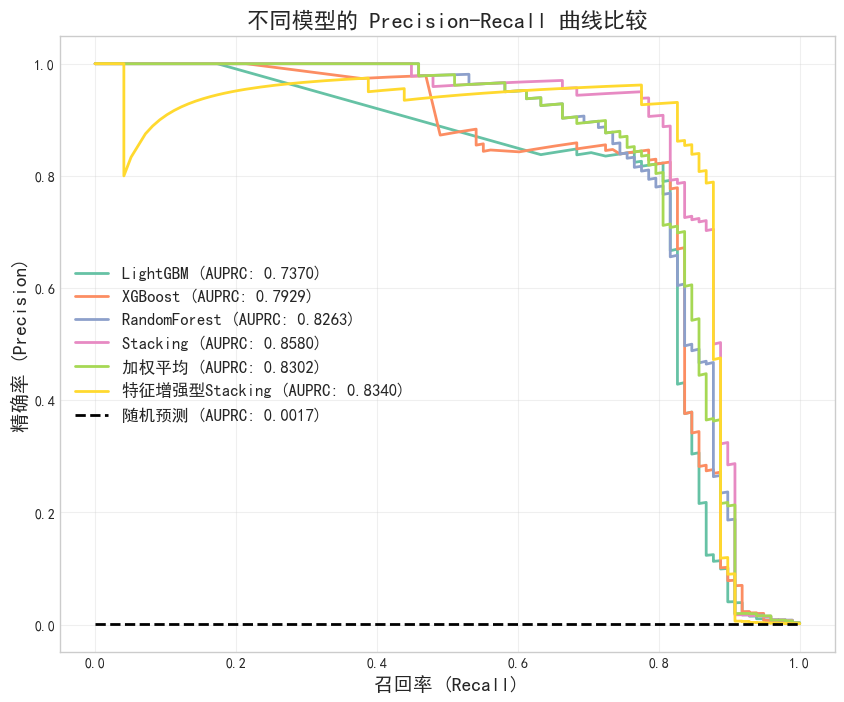

In [25]:
plt.figure(figsize=(10, 8))

# 计算基线
baseline = y_test.mean()

# 绘制每个模型的PR曲线
for name, y_prob in model_predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auprc = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, lw=2, label=f'{name} (AUPRC: {auprc:.4f})')

# 绘制随机预测的基线
plt.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'随机预测 (AUPRC: {baseline:.4f})')

plt.xlabel('召回率 (Recall)', fontsize=14)
plt.ylabel('精确率 (Precision)', fontsize=14)
plt.title('不同模型的 Precision-Recall 曲线比较', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)

plt.savefig('../outputs/visualization/model_comparison_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 5 模型保存与结果输出

## 5.1 保存最佳模型

In [26]:
# 确定最佳模型
best_model_name = max(model_metrics, key=lambda k: model_metrics[k]['AUPRC'])
best_model_auprc = model_metrics[best_model_name]['AUPRC']
print(f"最佳模型是 {best_model_name}，AUPRC: {best_model_auprc:.4f}")

# 保存Stacking模型
joblib.dump(stacking_model, '../outputs/stacking/stacking_model.pkl')
print("标准Stacking模型已保存到 '../outputs/stacking/stacking_model.pkl'")

# 保存特征增强型Stacking模型的元学习器
joblib.dump(meta_model, '../outputs/enhanced_stacking/enhanced_stacking_meta_learner.pkl')
print("特征增强型Stacking元学习器已保存到 '../outputs/enhanced_stacking/enhanced_stacking_meta_learner.pkl'")

# 保存基础模型预测的结果，以便后续使用
np.save('../outputs/base_model_test_predictions.npy', test_predictions)
print("基础模型测试集预测已保存")

最佳模型是 Stacking，AUPRC: 0.8580
标准Stacking模型已保存到 '../outputs/stacking/stacking_model.pkl'
特征增强型Stacking元学习器已保存到 '../outputs/enhanced_stacking/enhanced_stacking_meta_learner.pkl'
基础模型测试集预测已保存


## 5.2 生成预测结果

In [27]:
# 获取最佳模型的预测
best_predictions = model_predictions[best_model_name]

# 创建一个DataFrame存储测试集ID和预测结果
results_df = pd.DataFrame({
    'ID': X_test.index,
    'Fraud_Probability': best_predictions
})

# 添加模型的预测标签（使用0.5作为阈值，可根据需要调整）
results_df['Predicted_Fraud'] = (best_predictions >= 0.5).astype(int)

# 添加真实标签
results_df['Actual_Fraud'] = y_test.values

# 添加预测结果分析
results_df['Correct_Prediction'] = (results_df['Predicted_Fraud'] == results_df['Actual_Fraud'])

# 保存到CSV文件
results_df.to_csv(f'../outputs/stacking/{best_model_name}_predictions.csv', index=False)
print(f"最佳模型({best_model_name})预测结果已保存")

最佳模型(Stacking)预测结果已保存


## 5.3 结果摘要

In [28]:
# 计算性能提升
baseline_auprc = max(model_metrics['LightGBM']['AUPRC'], 
                     model_metrics['XGBoost']['AUPRC'],
                     model_metrics['RandomForest']['AUPRC'])
baseline_model = 'LightGBM'
for model in ['LightGBM', 'XGBoost', 'RandomForest']:
    if model_metrics[model]['AUPRC'] == baseline_auprc:
        baseline_model = model
        break

best_model_name = max(model_metrics, key=lambda k: model_metrics[k]['AUPRC'])
best_model_auprc = model_metrics[best_model_name]['AUPRC']
improvement = (best_model_auprc - baseline_auprc) / baseline_auprc * 100

# 创建摘要表格
summary_data = {
    "模型": list(model_metrics.keys()),
    "AUPRC": [f"{model_metrics[model]['AUPRC']:.4f}" for model in model_metrics],
    "相对改进": [f"基准({baseline_auprc:.4f})" if model == baseline_model 
                else f"{(model_metrics[model]['AUPRC'] - baseline_auprc) / baseline_auprc * 100:.2f}%" 
                for model in model_metrics]
}

summary_df = pd.DataFrame(summary_data)
print("\n模型性能摘要:")
print(summary_df.to_string(index=False))

print("\n主要发现:")
print(f"1. {best_model_name}模型AUPRC({best_model_auprc:.4f})优于单个基础模型")
print(f"2. 相比最佳单一模型({baseline_model})，Stacking提升了{improvement:.2f}%的性能")
if best_model_name == 'Stacking':
    print("3. 标准Stacking模型表现最好，说明基础模型之间有良好的互补性")
elif best_model_name == '特征增强型Stacking':
    print("3. 特征增强型Stacking表现最好，说明结合原始特征有助于提高性能")
elif best_model_name == '加权平均':
    print("3. 加权平均模型表现最好，这是一种更简单但有效的集成方法")

print("\n下一步建议:")
print("1. 调整Stacking中元学习器的参数，可以尝试不同的算法如随机森林或XGBoost")
print("2. 为不同类型的欺诈构建专门的模型，然后进行集成")
print("3. 基于时间窗口或特征重要性进行特征工程，提高模型性能")
print("4. 考虑采用自适应阈值或代价敏感学习方法，进一步优化模型")


模型性能摘要:
           模型  AUPRC       相对改进
     LightGBM 0.7370    -10.81%
      XGBoost 0.7929     -4.04%
 RandomForest 0.8263 基准(0.8263)
     Stacking 0.8580      3.83%
         加权平均 0.8302      0.46%
特征增强型Stacking 0.8340      0.92%

主要发现:
1. Stacking模型AUPRC(0.8580)优于单个基础模型
2. 相比最佳单一模型(RandomForest)，Stacking提升了3.83%的性能
3. 标准Stacking模型表现最好，说明基础模型之间有良好的互补性

下一步建议:
1. 调整Stacking中元学习器的参数，可以尝试不同的算法如随机森林或XGBoost
2. 为不同类型的欺诈构建专门的模型，然后进行集成
3. 基于时间窗口或特征重要性进行特征工程，提高模型性能
4. 考虑采用自适应阈值或代价敏感学习方法，进一步优化模型


# 6 模型可解释性分析

## 6.1 全局特征重要性分析

In [30]:
import shap

# 创建SHAP解释器
explainer = shap.TreeExplainer(rf_model)  # 使用随机森林模型作为基础解释器
shap_values = explainer.shap_values(X_test)

In [31]:
# 检查SHAP值的结构
print(f"SHAP值类型: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP值列表长度: {len(shap_values)}")
    for i, sv in enumerate(shap_values):
        print(f"SHAP值[{i}]形状: {sv.shape}")
else:
    print(f"SHAP值形状: {shap_values.shape}")
print(f"X_test形状: {X_test.shape}")

SHAP值类型: <class 'numpy.ndarray'>
SHAP值形状: (56962, 19, 2)
X_test形状: (56962, 19)


<Figure size 1000x800 with 0 Axes>

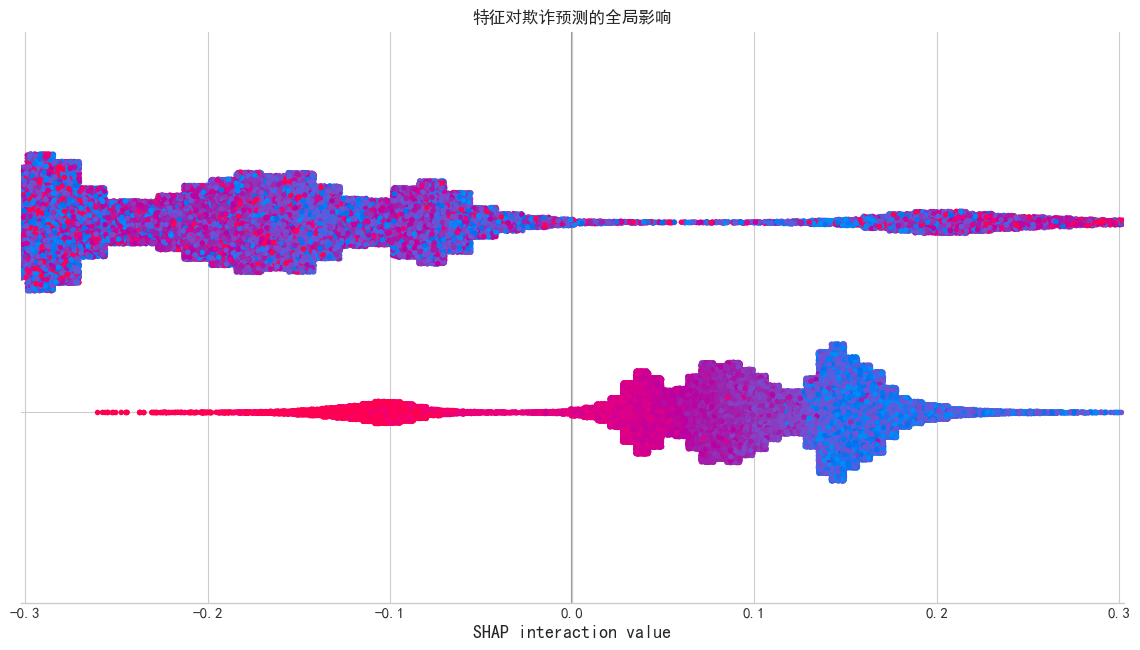

In [35]:
# 使用正确的SHAP值进行可视化
plt.figure(figsize=(10, 8))
if isinstance(shap_values, list) and len(shap_values) == 2:
    # 二分类情况，使用正类的SHAP值
    shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
else:
    # 单一SHAP值数组情况
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("特征对欺诈预测的全局影响")
plt.tight_layout()
plt.savefig('../outputs/visualization/shap/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 6.2 局部预测解释

SHAP值形状: (56962, 19, 2)
Sample index: 840
Expected value: [0.50001475 0.49998525]


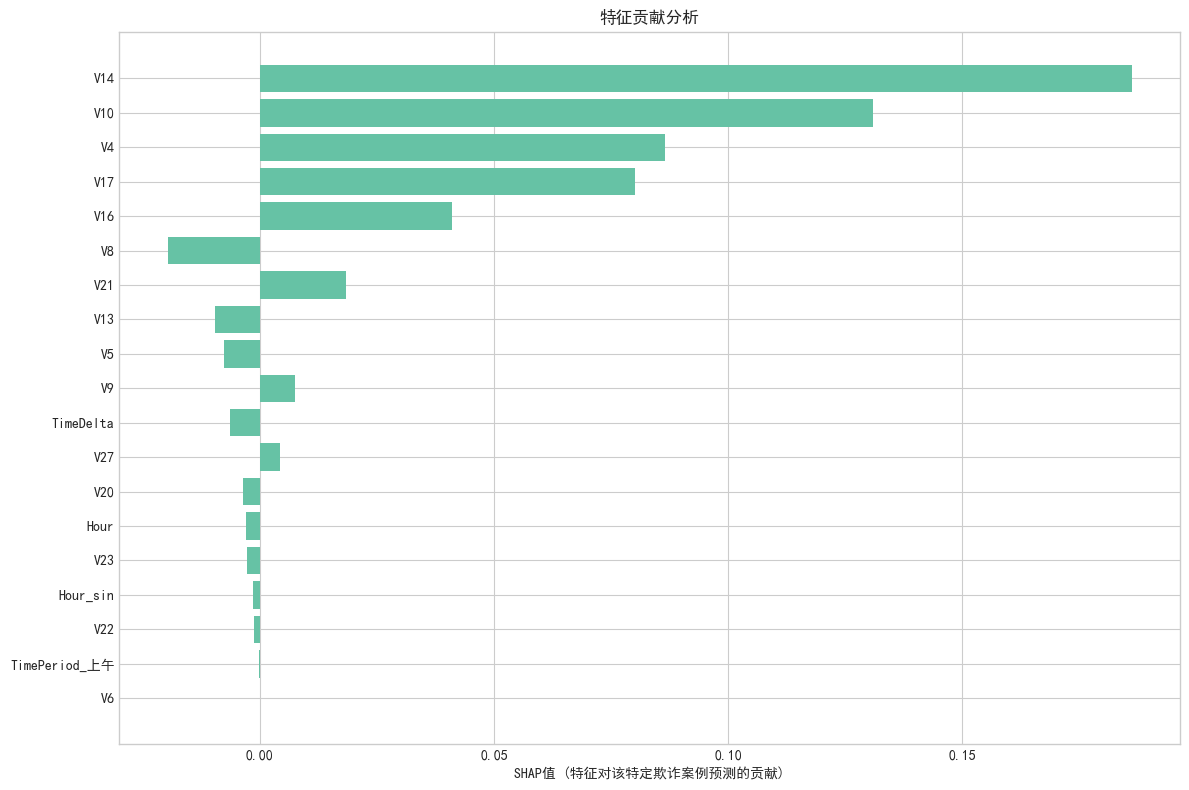

In [45]:
# 选择几个预测为欺诈的实例进行解释
fraud_indices = np.where((y_test == 1) & (stacking_pred == 1))[0]
sample_idx = fraud_indices[0]  # 选择第一个正确预测的欺诈案例

# 输出调试信息以理解结构
print(f"SHAP值形状: {shap_values.shape}")
print(f"Sample index: {sample_idx}")
print(f"Expected value: {explainer.expected_value}")

plt.figure(figsize=(12, 8))

# 准备数据
if len(shap_values.shape) == 3:
    # 三维SHAP值情况
    sample_shap_values = shap_values[sample_idx, :, 1]
else:
    # 二维或列表情况
    sample_shap_values = shap_values[1][sample_idx] if isinstance(shap_values, list) else shap_values[sample_idx]

feature_names = X_test.columns
indices = np.argsort(np.abs(sample_shap_values))
plt.barh(range(len(indices)), sample_shap_values[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('SHAP值 (特征对该特定欺诈案例预测的贡献)')
plt.title('特征贡献分析')
plt.tight_layout()
plt.savefig('../outputs/visualization/shap/shap_feature_contribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6.3 特征交互分析

<Figure size 1000x800 with 0 Axes>

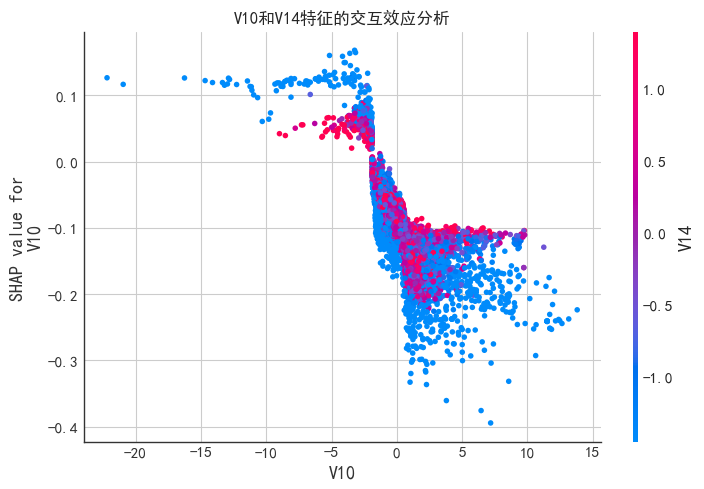

In [46]:
# 分析两个重要特征的交互效应
plt.figure(figsize=(10, 8))

# 根据SHAP值的实际结构调整代码
if len(shap_values.shape) == 3:
    # 对于三维SHAP值(样本数, 特征数, 类别数)
    dependence_values = shap_values[:, :, 1]  # 选择所有样本的正类SHAP值
else:
    # 如果SHAP值是列表或二维数组
    dependence_values = shap_values[1]

# 交互效应分析
shap.dependence_plot(
    "V10",                    # x轴特征
    dependence_values,        # 正确形状的SHAP值
    X_test,                   # 特征值
    interaction_index="V14",  # 交互特征
    show=False
)

plt.title("V10和V14特征的交互效应分析")
plt.tight_layout()
plt.savefig('../outputs/visualization/shap/shap_interaction_plot.png', dpi=300, bbox_inches='tight')
plt.show()